# Creating a Llama 3.1 LoRA adapter with NeMo Framework using a Synthetic Dataset

This notebook showcases performing LoRA finetuning on **Llama 3.1-8B** with a synthetically augmented version of [Law Stack Exchange](https://huggingface.co/datasets/ymoslem/Law-StackExchange) dataset using NeMo Framework. Law StackExchange is a dataset of legal question/answers. Each record consists of a question, its title, as well as human-provided answers.

For this demonstration, we will tune the model on the task of title/subject generation, that is, given a Law Stack Exchange forum question, auto-generate an appropriate title for it.


## Pre-requisites and Configurations

> **NOTE:** Run this notebook inside the [NeMo Framework container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/nemo) which includes all required dependencies. See the tutorial README for instructions on downloading the container.

In [1]:
%%capture

!apt-get update && apt-get install -y graphviz
!pip install ipywidgets

In [2]:
import os

os.environ["NEMO_DATASETS_CACHE"] = "/nemo-experiments/data-cache-chat"
os.environ["NEMO_MODELS_CACHE"] = "/nemo-experiments/models/"


# Configure the number of GPUs to use
NUM_GPU_DEVICES = 4

(Required) Configure your HuggingFace token

In [ ]:
from getpass import getpass

from huggingface_hub import login

# login(token=getpass("Input your HF Access Token"))
login(token="")

(Optional) Configure your WandB token for experiment tracking.

Leave empty and press "Enter" when prompted if you don't wish to configure.

In [ ]:
import wandb

# WANDB_API_KEY = getpass("Your Wandb API Key:")
WANDB_API_KEY = ""

wandb.login(key=WANDB_API_KEY)



---
## Step 1. Import the Hugging Face Checkpoint
We use the `llm.import_ckpt` API to download the specified model using the "hf://<huggingface_model_id>" URL format. It will then convert the model into NeMo 2.0 format. For all model supported in NeMo 2.0, refer to [Large Language Models](https://docs.nvidia.com/nemo-framework/user-guide/24.09/llms/index.html#large-language-models) section of NeMo Framework User Guide.

In [5]:
from pathlib import Path

import lightning.pytorch as pl
import nemo_run as run
from megatron.core.optimizer import OptimizerConfig
from nemo import lightning as nl
from nemo.collections import llm
from nemo.collections.llm.recipes.precision.mixed_precision import bf16_mixed

[NeMo W 2025-08-05 02:19:47 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    


llm.import_ckpt is the Nemo2 API for converting Hugging Face checkpoint to NeMo format
example python usage:

```python
llm.import_ckpt(model=llm.llama3_8b.model(), source="hf://meta-llama/Meta-Llama-3.1-8B")
```
Below we wrap this with run.Partial to configure it, and then we execute it


In [6]:

# We use run.Partial from NeMo-Run to configure this function
def configure_checkpoint_conversion():
    return run.Partial(
        llm.import_ckpt,
        model=llm.llama31_8b.model(),
        source="hf://meta-llama/Llama-3.1-8B",
        overwrite=False,
    )


# configure your function
import_ckpt = configure_checkpoint_conversion()

# define your executor
local_executor = run.LocalExecutor()

# run your experiment
run.run(import_ckpt, executor=local_executor)

─ Entering Experiment nemo.collections.llm.api.import_ckpt with id: nemo.collections.llm.api.import_ckpt_1754360… ─

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.import_ckpt/nemo.collections.llm.api.import_ckpt_1754360388/nemo.collections.llm.api.import_ckpt


[02:19:49] Launching job nemo.collections.llm.api.import_ckpt for experiment                      ]8;id=924464;file:///opt/Run/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=639015;file:///opt/Run/nemo_run/run/experiment.py#771\771]8;;\
           nemo.collections.llm.api.import_ckpt                                                                    

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.import_ckpt/nemo.collections.llm.api.import_ckpt_1754360388/nemo.collections.llm.api.import_ckpt
Launched app: local_persistent://nemo_run/nemo.collections.llm.api.import_ckpt-mpkfjns3cmtql


──────────────── Waiting for Experiment nemo.collections.llm.api.import_ckpt_1754360388 to finish ─────────────────

Experiment Status for nemo.collections.llm.api.import_ckpt_1754360388

Task 0: nemo.collections.llm.api.import_ckpt
- Status: RUNNING
- Executor: LocalExecutor
- Job id: nemo.collections.llm.api.import_ckpt-mpkfjns3cmtql
- Local Directory: /root/.nemo_run/experiments/nemo.collections.llm.api.import_ckpt/nemo.collections.llm.api.import_ckpt_1754360388/nemo.collections.llm.api.import_ckpt

Waiting for job nemo.collections.llm.api.import_ckpt-mpkfjns3cmtql to finish [log=True]...


mport_ckpt/0 [NeMo W 2025-08-05 02:20:00 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
mport_ckpt/0       warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
mport_ckpt/0     
mport_ckpt/0  $NEMO_MODELS_CACHE=/nemo-experiments/models 
mport_ckpt/0 Imported Checkpoint
mport_ckpt/0 ├── context/
mport_ckpt/0 │   ├── artifacts/
mport_ckpt/0 │   │   └── generation_config.json
mport_ckpt/0 │   ├── nemo_tokenizer/
mport_ckpt/0 │   │   ├── special_tokens_map.json
mport_ckpt/0 │   │   ├── tokenizer.json
mport_ckpt/0 │   │   └── tokenizer_config.json
mport_ckpt/0 │   ├── io.json
mport_ckpt/0 │   └── model.yaml
mport_ckpt/0 └── weights/
mport_ckpt/0     ├── .metadata
mport_ckpt/0     ├── __0_0.distcp
mport_ckpt/0     ├── __0_1.distcp
mport_ckpt/0     ├── common.pt
mport_ckpt/0     └── metadata.json


Job nemo.collections.llm.api.import_ckpt-mpkfjns3cmtql finished: SUCCEEDED


                                                                                                                   
# The experiment was run with the following tasks: ['nemo.collections.llm.api.import_ckpt']                        
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("nemo.collections.llm.api.import_ckpt_1754360388")                             
experiment.status() # Gets the overall status                                                                      
experiment.logs("nemo.collections.llm.api.import_ckpt") # Gets the log for the provided task                       
experiment.cancel("nemo.collections.llm.api.import_ckpt") # Cancels the provided task if still running             
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status nemo.collections.llm.api.import_ckpt_1754360388                                             
nemo experiment logs nemo.collections.llm.api.import_ckpt_1754360388 0                                             
nemo experiment cancel nemo.collections.llm.api.import_ckpt_1754360388 0                                           
                                                                                                                   

The above steps downloads the checkpoint from HuggingFace, converts it to NeMo format, and saves it to the directory specified by the `NEMO_MODELS_CACHE` environment variable.

In [7]:
!ls $NEMO_MODELS_CACHE/meta-llama/Llama-3.1-8B

context  weights


---
## Step 2. Prepare the Data and Customize the DataModule


NeMo 2.0 provides a generic `FineTuningDataModule` class that you can extend for custom preprocessing.

To use your own data, subclass `FineTuningDataModule` to leverage existing data handling logic (e.g., packed sequences). You may see the [`FineTuningDataModule`](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/llm/gpt/data/fine_tuning.py) class for reference.

For more data modules (including [Chat](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/llm/gpt/data/chat.py)), refer to the [data module directory](https://github.com/NVIDIA/NeMo/tree/main/nemo/collections/llm/gpt/data).

Below, we extend the `FineTuningDataModule` for the LawStackExchange dataset. Beyond all the boilerplate code, take note of the two methods, that we tweak -
1. `_download_data()` that downloads the dataset
2. `_preprocess_and_split_data()` has any cleaning and splitting logic, to prepare the dataset as **train/val/test.jsonl** files

In [ ]:
%%writefile lse_datamodule.py

import json
import re
import shutil
from typing import TYPE_CHECKING, Any, Dict, List, Optional

import numpy as np
from datasets import load_dataset
from nemo.collections.llm.gpt.data.core import get_dataset_root
from nemo.collections.llm.gpt.data.fine_tuning import FineTuningDataModule
from nemo.lightning.io.mixin import IOMixin
from nemo.utils import logging


class LawStackExchangeDataModule(FineTuningDataModule, IOMixin):
    def __init__(
        self,
        seq_length: int = 2048,
        tokenizer: Optional["TokenizerSpec"] = None,
        micro_batch_size: int = 4,
        global_batch_size: int = 8,
        rampup_batch_size: Optional[List[int]] = None,
        force_redownload: bool = False,
        delete_raw: bool = True,
        seed: int = 1234,
        memmap_workers: int = 1,
        num_workers: int = 8,
        pin_memory: bool = True,
        persistent_workers: bool = False,
        packed_sequence_specs: Optional["PackedSequenceSpecs"] = None,
        dataset_kwargs: Optional[Dict[str, Any]] = None,
    ):
        self.force_redownload = force_redownload
        self.delete_raw = delete_raw

        super().__init__(
            dataset_root=get_dataset_root("lse"),
            seq_length=seq_length,
            tokenizer=tokenizer,
            micro_batch_size=micro_batch_size,
            global_batch_size=global_batch_size,
            rampup_batch_size=rampup_batch_size,
            seed=seed,
            memmap_workers=memmap_workers,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
            packed_sequence_specs=packed_sequence_specs,
            dataset_kwargs=dataset_kwargs,
        )

    def prepare_data(self) -> None:
        # if train file is specified, no need to do anything
        if not self.train_path.exists() or self.force_redownload:
            dset = self._download_data()
            self._preprocess_and_split_data(dset)
        super().prepare_data()

    def _download_data(self):
        logging.info(f"Downloading {self.__class__.__name__}...")
        return load_dataset(
            "ymoslem/Law-StackExchange",
            cache_dir=str(self.dataset_root),
            download_mode="force_redownload" if self.force_redownload else None,
        )

    def _preprocess_and_split_data(
        self, dset, train_ratio: float = 0.85, val_ratio: float = 0.13
    ):
        print(
            f"Preprocessing {self.__class__.__name__} to jsonl format and splitting..."
        )

        test_ratio = 1 - train_ratio - val_ratio
        save_splits = {}
        dataset = dset.get("train")
        split_dataset = dataset.train_test_split(
            test_size=val_ratio + test_ratio, seed=self.seed
        )
        split_dataset2 = split_dataset["test"].train_test_split(
            test_size=test_ratio / (val_ratio + test_ratio), seed=self.seed
        )
        save_splits["training"] = split_dataset["train"]
        save_splits["validation"] = split_dataset2["train"]
        save_splits["test"] = split_dataset2["test"]

        for split_name, dataset in save_splits.items():
            print(f"Processing {split_name} split ...")
            output_file = self.dataset_root / f"{split_name}.jsonl"
            with output_file.open("w", encoding="utf-8") as f:
                for example in dataset:
                    # Cleanup - Remove HTML tags from the question body
                    cleaned_question_body = re.sub(
                        "<[^<]+?>", "", example["question_body"]
                    )

                    # Create the formatted input string
                    input_text = (
                        "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum."
                        f"\nQUESTION: {cleaned_question_body.strip()} \nTITLE: "
                    )

                    # Write the JSON object to the file
                    json_line = json.dumps(
                        {"input": input_text, "output": example["question_title"]}
                    )
                    f.write(json_line + "\n")

            print(f"{split_name} split saved to {output_file}")

        if self.delete_raw:
            for p in self.dataset_root.iterdir():
                if p.is_dir():
                    shutil.rmtree(p)
                elif ".jsonl" not in str(p.name):
                    p.unlink()

Overwriting lse_datamodule.py


For more data modules (including [Chat](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/llm/gpt/data/chat.py)), refer to the [data module directory](https://github.com/NVIDIA/NeMo/tree/main/nemo/collections/llm/gpt/data).


The following code does a sanity check, and visualizes the data

In [9]:
from lse_datamodule import LawStackExchangeDataModule

test_datamodule = LawStackExchangeDataModule(
    seq_length=2048, micro_batch_size=1, global_batch_size=8
)

test_datamodule.prepare_data()  # Downloads and preprocesses

In [10]:
!head -n1 {test_datamodule.train_path}

{"input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUESTION: Suppose person A tells person B, \"If you perform (service X) for me, I will donate $1,000 to Save the Whales (but no other compensation).\" Neither A nor B has any connection to whales and will not benefit from this donation, but B happens to like whales and agrees anyway. Does this still count as consideration, even though there was never any possibility of B getting anything out of it? (United States) \nTITLE: ", "output": "Does consideration have to have value for someone who is a party to the contract?"}


 Example format:
 - "input" contains the prompt plus user question
 - "output" contains the the desired autogenerated post title


```json
{
    "input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUESTION: Suppose person A tells person B, \"If you perform (service X) for me, I will donate $1,000 to Save the Whales (but no other compensation).\" Neither A nor B has any connection to whales and will not benefit from this donation, but B happens to like whales and agrees anyway. Does this still count as consideration, even though there was never any possibility of B getting anything out of it? (United States) \nTITLE: ", 
    "output": "Does consideration have to have value for someone who is a party to the contract?"
}

Each data example is saved as a json string as one line in the `train/validation/test.jsonl` file, under `NEMO_DATASETS_CACHE` directory you specified earlier.

In [11]:
# Check the number of lines in the train, validation, and test files
!wc -l {test_datamodule.train_path}
!wc -l {test_datamodule.validation_path}
!wc -l {test_datamodule.test_path}

19496 /nemo-experiments/data-cache-chat/lse/training.jsonl
3655 /nemo-experiments/data-cache-chat/lse/validation.jsonl
1219 /nemo-experiments/data-cache-chat/lse/test.jsonl


Now that we've validated that the data preparation works as expected, the following code wraps the `LawStackExchangeDataModule` into a run.Config object that can be passed during training.

In [12]:
def lse_data() -> run.Config[pl.LightningDataModule]:
    return run.Config(
        LawStackExchangeDataModule,
        seq_length=2048,
        micro_batch_size=4,
        global_batch_size=16,
        num_workers=0,
    )


## (Optional) Synthetic Data Generation using NeMo Curator

If you are following the tutorial to augment this data with [synthetic data generation using NeMo Curator](https://github.com/NVIDIA/NeMo-Curator/tree/main/tutorials/peft-curation-with-sdg), your steps above would look slightly different.

You may follow the [documentation](https://docs.nvidia.com/nemo-framework/user-guide/latest/data/finetune_data.html#option-2-use-finetuningdatamodule-with-preprocessed-data) for using the `FineTuningDataModule` directly by pointing them to the prepared .jsonl files.

1. Organize your data into a directory like
```bash
curated-data
    ├── training.jsonl
    ├── validation.jsonl
    └── test.jsonl
```

2. Then you may define your data module as

```python

def lse_data() -> run.Config[pl.LightningDataModule]:
    return run.Config(
        FineTuningDataModule,
        dataset_root="/path/to/curated-data",
        seq_length=2048,
        micro_batch_size=4,
        global_batch_size=16,
        num_workers=0,
    )
```

---

## Step 3: Configure LoRA with the NeMo 2.0 API 

First we configure the following components for training. These components are similar between SFT and PEFT (LoRA). SFT and PEFT both uses `llm.finetune` API. To switch from PEFT to SFT, you just need to remove the `peft` parameter.

### 3.1: Configure the Trainer
The NeMo 2.0 Trainer works similarly to the PyTorch Lightning trainer.

In [13]:
def trainer() -> run.Config[nl.Trainer]:
    strategy = run.Config(nl.MegatronStrategy, tensor_model_parallel_size=1)
    trainer = run.Config(
        nl.Trainer,
        devices=NUM_GPU_DEVICES,
        max_steps=1000,
        accelerator="gpu",
        strategy=strategy,
        plugins=bf16_mixed(),
        log_every_n_steps=1,
        limit_val_batches=2,
        val_check_interval=10,
        num_sanity_val_steps=0,
    )
    return trainer


### 3.2: Configure the Logger
Configure your training steps, output directories and logging through `NeMoLogger`. In the following example, the experiment output will be saved at `log_dir`.

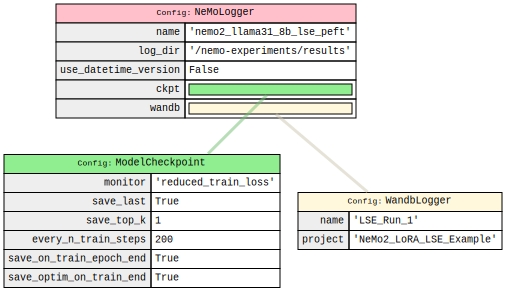

In [27]:
from lightning.pytorch.loggers import WandbLogger

LOG_DIR = "/nemo-experiments/results"
LOG_NAME = "nemo2_llama31_8b_lse_peft"

def logger() -> run.Config[nl.NeMoLogger]:
    ckpt = run.Config(
        nl.ModelCheckpoint,
        save_last=True,
        every_n_train_steps=200,
        monitor="reduced_train_loss",
        save_top_k=1,
        save_on_train_epoch_end=True,
        save_optim_on_train_end=True,
    )


    if WANDB_API_KEY is not None and WANDB_API_KEY != "":
        wandb_config = run.Config(
            WandbLogger, project="NeMo2_LoRA_LSE_Example", name="LSE_Run_1"
        )
    else:
        wandb_config = None

    return run.Config(
        nl.NeMoLogger,
        name=LOG_NAME,
        log_dir=LOG_DIR,
        use_datetime_version=False,
        ckpt=ckpt,
        wandb=wandb_config,
    )


logger()

### 3.3: Configure the Optimizer
In the following example, we will be using the distributed adam optimizer and pass in the optimizer configuration through `OptimizerConfig`: 

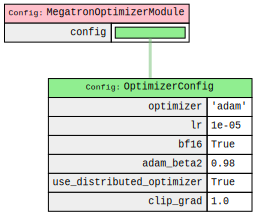

In [15]:
def adam_with_cosine_annealing() -> run.Config[nl.OptimizerModule]:
    opt_cfg = run.Config(
        OptimizerConfig,
        optimizer="adam",
        lr=1e-5,
        adam_beta2=0.98,
        use_distributed_optimizer=True,
        clip_grad=1.0,
        bf16=True,
    )
    return run.Config(nl.MegatronOptimizerModule, config=opt_cfg)


adam_with_cosine_annealing()

### 3.4: Configure the Base Model
We will perform SFT on top of Llama 3-8B, so we instantiate a `LlamaModel` configuration to pass to the finetune API. This specifies the structure to load the weights imported previously in Step 1.

In [16]:
def llama31_8b() -> run.Config[pl.LightningModule]:
    return run.Config(llm.LlamaModel, config=run.Config(llm.Llama31Config8B))

### 3.5: Configure Auto Resume
Resume training from the imported checkpoint (`nemo://meta-llama/Llama-3.1-8B`).

Set `resume_if_exists=True` to automatically continue from the latest checkpoint (in case of previous finetuning experiments) if available.

In [17]:
def resume() -> run.Config[nl.AutoResume]:
    return run.Config(
        nl.AutoResume,
        restore_config=run.Config(
            nl.RestoreConfig, path="nemo://meta-llama/Llama-3.1-8B"
        ),
        resume_if_exists=False,
    )

### 3.6:  Configure the LoRA adapter

In this step, you may choose LoRA configurations like adapter dimension, LoRA alpha, as well as target modules. By default, it applies an adapter to all the linear layers.

In [18]:
from nemo.collections.llm.peft.lora import LoRA

def lora() -> run.Config[nl.pytorch.callbacks.PEFT]:
    return run.Config(LoRA,
                      dim=8,
                      alpha=32,
                      dropout=0.1,
                      )


### 3.7: Configure NeMo 2.0 finetune API
Using all the components we created above, the following code configures the NeMo 2.0 finetune API.

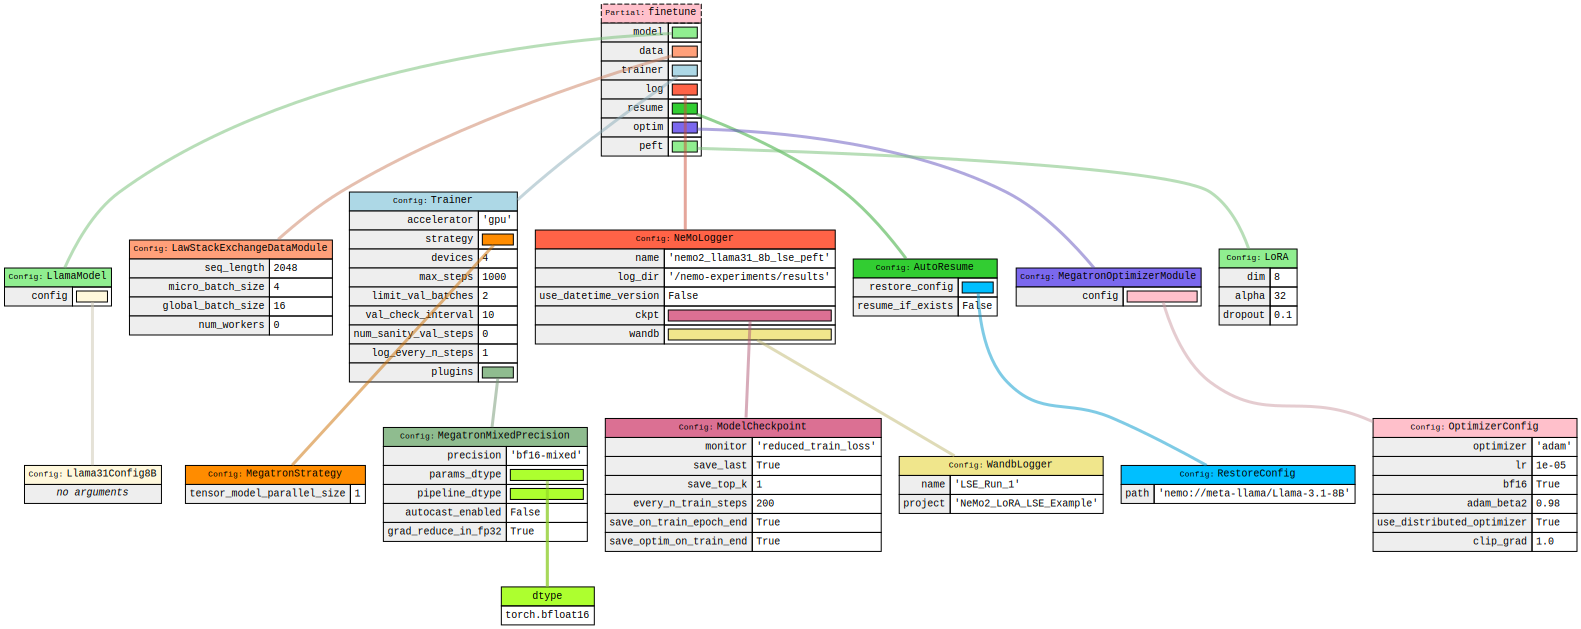

In [19]:
def configure_finetuning_recipe():
    return run.Partial(
        llm.finetune,
        model=llama31_8b(),
        trainer=trainer(),
        data=lse_data(),
        log=logger(),
        optim=adam_with_cosine_annealing(),
        peft=lora(),
        resume=resume(),
    )


configure_finetuning_recipe()

## 3.8: Execute LoRA tuning with NeMo-Run

We use `LocalExecutor` for executing our configured finetune function. 

> **NOTE:** You may just as easily run the workflow remotely on a SLURM cluster, or a cloud environment, from the comfort of this Jupyter notebook. That is really the benefit of using NeMo-Run for scalable experimentation. For more details on the NeMo-Run executor, refer to [Execute NeMo Run](https://github.com/NVIDIA/NeMo-Run/blob/main/docs/source/guides/execution.md) of NeMo-Run Guides.


In [20]:
def local_executor_torchrun(nodes: int = 1, devices: int = 2) -> run.LocalExecutor:
    # Env vars for jobs are configured here
    env_vars = {
        "TORCH_NCCL_AVOID_RECORD_STREAMS": "1",
        "NCCL_NVLS_ENABLE": "0",
    }

    executor = run.LocalExecutor(
        ntasks_per_node=devices, launcher="torchrun", env_vars=env_vars
    )

    return executor


if __name__ == "__main__":
    run.run(
        configure_finetuning_recipe(),
        executor=local_executor_torchrun(devices=NUM_GPU_DEVICES),
    )

─── Entering Experiment nemo.collections.llm.api.finetune with id: nemo.collections.llm.api.finetune_1754360413 ───

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.finetune/nemo.collections.llm.api.finetune_1754360413/nemo.collections.llm.api.finetune


[02:20:13] Launching job nemo.collections.llm.api.finetune for experiment                         ]8;id=369630;file:///opt/Run/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=955647;file:///opt/Run/nemo_run/run/experiment.py#771\771]8;;\
           nemo.collections.llm.api.finetune                                                                       

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.finetune/nemo.collections.llm.api.finetune_1754360413/nemo.collections.llm.api.finetune
Launched app: local_persistent://nemo_run/nemo.collections.llm.api.finetune-lml31tqlql04pc


────────────────── Waiting for Experiment nemo.collections.llm.api.finetune_1754360413 to finish ──────────────────

Experiment Status for nemo.collections.llm.api.finetune_1754360413

Task 0: nemo.collections.llm.api.finetune
- Status: RUNNING
- Executor: LocalExecutor
- Job id: nemo.collections.llm.api.finetune-lml31tqlql04pc
- Local Directory: /root/.nemo_run/experiments/nemo.collections.llm.api.finetune/nemo.collections.llm.api.finetune_1754360413/nemo.collections.llm.api.finetune

Waiting for job nemo.collections.llm.api.finetune-lml31tqlql04pc to finish [log=True]...


i.finetune/0 I0805 02:20:15.692000 8757 torch/distributed/run.py:649] Using nproc_per_node=4.
i.finetune/0 W0805 02:20:15.692000 8757 torch/distributed/run.py:766] 
i.finetune/0 W0805 02:20:15.692000 8757 torch/distributed/run.py:766] *****************************************
i.finetune/0 W0805 02:20:15.692000 8757 torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
i.finetune/0 W0805 02:20:15.692000 8757 torch/distributed/run.py:766] *****************************************
i.finetune/0 I0805 02:20:15.693000 8757 torch/distributed/launcher/api.py:195] Starting elastic_operator with launch configs:
i.finetune/0 I0805 02:20:15.693000 8757 torch/distributed/launcher/api.py:195]   entrypoint       : nemo_run.core.runners.fdl_runner
i.finetune/0 I0805 02:20:15.693000 8757 torch/distributed/launcher/api.p

Job nemo.collections.llm.api.finetune-lml31tqlql04pc finished: SUCCEEDED


                                                                                                                   
# The experiment was run with the following tasks: ['nemo.collections.llm.api.finetune']                           
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("nemo.collections.llm.api.finetune_1754360413")                                
experiment.status() # Gets the overall status                                                                      
experiment.logs("nemo.collections.llm.api.finetune") # Gets the log for the provided task                          
experiment.cancel("nemo.collections.llm.api.finetune") # Cancels the provided task if still running                
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status nemo.collections.llm.api.finetune_1754360413                                                
nemo experiment logs nemo.collections.llm.api.finetune_1754360413 0                                                
nemo experiment cancel nemo.collections.llm.api.finetune_1754360413 0                                              
                                                                                                                   

---
## Step 4. Run In-Framework Generation

For a sanity check, we use the `llm.generate` API in NeMo 2.0 to generate results from the trained checkpoint. Find your last saved checkpoint from your experiment `results` dir:

In [28]:
sft_ckpt_path = str(
    next(
        (
            d
            for d in Path(
                LOG_DIR + "/" + LOG_NAME + "/checkpoints/"
            ).iterdir()
            if d.is_dir() and d.name.endswith("-last")
        ),
        None,
    )
)
print("We will load SFT checkpoint from:", sft_ckpt_path)

We will load SFT checkpoint from: /nemo-experiments/results/nemo2_llama31_8b_lse_peft/checkpoints/nemo2_llama31_8b_lse_peft--reduced_train_loss=1.3045-epoch=0-consumed_samples=16000.0-last


When using the `llm.generate` API, you can provide a data module, for example: `input_dataset=lse_data()`. This will use the test set from the specified data module to generate predictions. In the example below, the generated predictions are saved to the `peft_predictions.txt` file.

Generating predictions needs only 1 GPU (`tensor_model_parallel_size=1`). However, using multiple GPU devices can speed up inference.

> **Note:** The following cell may take about 20 minutes to complete.

In [29]:
from megatron.core.inference.common_inference_params import CommonInferenceParams


def trainer() -> run.Config[nl.Trainer]:
    strategy = run.Config(
        nl.MegatronStrategy,
        tensor_model_parallel_size=1,
    )
    trainer = run.Config(
        nl.Trainer,
        accelerator="gpu",
        devices=NUM_GPU_DEVICES,
        num_nodes=1,
        strategy=strategy,
        plugins=bf16_mixed(),
    )
    return trainer


def configure_inference():
    return run.Partial(
        llm.generate,
        path=str(sft_ckpt_path),
        trainer=trainer(),
        input_dataset=lse_data(),
        inference_params=CommonInferenceParams(num_tokens_to_generate=50, top_k=1),
        output_path="peft_prediction.jsonl",
    )


def local_executor_torchrun(nodes: int = 1, devices: int = 1) -> run.LocalExecutor:
    # Env vars for jobs are configured here
    env_vars = {
        "TORCH_NCCL_AVOID_RECORD_STREAMS": "1",
        "NCCL_NVLS_ENABLE": "0",
    }

    executor = run.LocalExecutor(
        ntasks_per_node=devices, launcher="torchrun", env_vars=env_vars
    )

    return executor


if __name__ == "__main__":
    run.run(
        configure_inference(), executor=local_executor_torchrun(devices=NUM_GPU_DEVICES)
    )

─── Entering Experiment nemo.collections.llm.api.generate with id: nemo.collections.llm.api.generate_1754365308 ───

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.generate/nemo.collections.llm.api.generate_1754365308/nemo.collections.llm.api.generate


[03:41:48] Launching job nemo.collections.llm.api.generate for experiment                         ]8;id=52367;file:///opt/Run/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=808446;file:///opt/Run/nemo_run/run/experiment.py#771\771]8;;\
           nemo.collections.llm.api.generate                                                                       

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.generate/nemo.collections.llm.api.generate_1754365308/nemo.collections.llm.api.generate
Launched app: local_persistent://nemo_run/nemo.collections.llm.api.generate-lkzx5v6ssdx4cc


────────────────── Waiting for Experiment nemo.collections.llm.api.generate_1754365308 to finish ──────────────────

Experiment Status for nemo.collections.llm.api.generate_1754365308

Task 0: nemo.collections.llm.api.generate
- Status: RUNNING
- Executor: LocalExecutor
- Job id: nemo.collections.llm.api.generate-lkzx5v6ssdx4cc
- Local Directory: /root/.nemo_run/experiments/nemo.collections.llm.api.generate/nemo.collections.llm.api.generate_1754365308/nemo.collections.llm.api.generate

Waiting for job nemo.collections.llm.api.generate-lkzx5v6ssdx4cc to finish [log=True]...


i.generate/0 I0805 03:41:49.960000 12109 torch/distributed/run.py:649] Using nproc_per_node=4.
i.generate/0 W0805 03:41:49.961000 12109 torch/distributed/run.py:766] 
i.generate/0 W0805 03:41:49.961000 12109 torch/distributed/run.py:766] *****************************************
i.generate/0 W0805 03:41:49.961000 12109 torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
i.generate/0 W0805 03:41:49.961000 12109 torch/distributed/run.py:766] *****************************************
i.generate/0 I0805 03:41:49.962000 12109 torch/distributed/launcher/api.py:195] Starting elastic_operator with launch configs:
i.generate/0 I0805 03:41:49.962000 12109 torch/distributed/launcher/api.py:195]   entrypoint       : nemo_run.core.runners.fdl_runner
i.generate/0 I0805 03:41:49.962000 12109 torch/distributed/launch

Job nemo.collections.llm.api.generate-lkzx5v6ssdx4cc finished: SUCCEEDED


                                                                                                                   
# The experiment was run with the following tasks: ['nemo.collections.llm.api.generate']                           
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("nemo.collections.llm.api.generate_1754365308")                                
experiment.status() # Gets the overall status                                                                      
experiment.logs("nemo.collections.llm.api.generate") # Gets the log for the provided task                          
experiment.cancel("nemo.collections.llm.api.generate") # Cancels the provided task if still running                
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status nemo.collections.llm.api.generate_1754365308                                                
nemo experiment logs nemo.collections.llm.api.generate_1754365308 0                                                
nemo experiment cancel nemo.collections.llm.api.generate_1754365308 0                                              
                                                                                                                   

After the inference is complete, you will see results similar to the following:

In [32]:
%%bash
head -n 10 peft_prediction.jsonl

{"input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUESTION: I bet most of you have heard - in some music compositions - short 5-10 seconds &quot;injections&quot; of voice-lines from some old movies.\nI'm producing a track right now, where I want to insert a phrase from &quot;Conan the Destroyer&quot; (1984), it's under 10 seconds in length. I wonder if such use is &quot;legal&quot;?\nI assume, due to neglectable short length of the sound-sample, it should be fine, but I just want to double-check. Any links to corresponding laws/acts would be appreciated, thanks. \nTITLE: ", "label": "Voice samples from the old movies in the music tracks", "prediction": "5-10 seconds of voice-line from old movie - is it legal to use in a music composition?"}
{"input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUE

In [3]:
!ls 

Curator			       lse_chatdatamodule.py
NeMo			       lse_datamodule.py
README_chat_templates.md       nemo-data-flywheel-tutorials
__pycache__		       nemo_experiments
bge-base-financial-matryoshka  peft_prediction.jsonl
convert_llama_embedding.py     sft_prediction.jsonl
convert_to_hf.py	       snap
data			       test
dms_logs.json		       test_dataset.json
example_usage.py	       train_dataset.json
fiqa_data		       unsloth_compiled_cache
gemma3_ticket_router	       virt-envs
go


In [2]:
%%bash
head -n 10 peft_prediction.jsonl

{"input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUESTION: I bet most of you have heard - in some music compositions - short 5-10 seconds &quot;injections&quot; of voice-lines from some old movies.\nI'm producing a track right now, where I want to insert a phrase from &quot;Conan the Destroyer&quot; (1984), it's under 10 seconds in length. I wonder if such use is &quot;legal&quot;?\nI assume, due to neglectable short length of the sound-sample, it should be fine, but I just want to double-check. Any links to corresponding laws/acts would be appreciated, thanks. \nTITLE: ", "label": "Voice samples from the old movies in the music tracks", "prediction": "5-10 seconds of voice-line from old movie - is it legal to use in a music composition?"}
{"input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUE

You should see output similar to the following:
```json
{
    "input": "Generate a concise, legally-relevant, and SEO-friendly title for the following legal question in the Law Stack Exchange internet forum.\nQUESTION: I bet most of you have heard - in some music compositions - short 5-10 seconds &quot;injections&quot; of voice-lines from some old movies.\nI'm producing a track right now, where I want to insert a phrase from &quot;Conan the Destroyer&quot; (1984), it's under 10 seconds in length. I wonder if such use is &quot;legal&quot;?\nI assume, due to neglectable short length of the sound-sample, it should be fine, but I just want to double-check. Any links to corresponding laws/acts would be appreciated, thanks. \nTITLE: ", 
    "label": "Voice samples from the old movies in the music tracks", 
    "prediction": "5-10 seconds of voice-line from old movie - is it legal to use in a music composition?"
}

```

---
## Step 5. Calculate Evaluation Metrics

We can evaluate the model's predictions by calculating the following metrics -
- **Exact Match** is a binary measure (0 or 1) checking if the model outputs match one of the
ground truth answer exactly.
- **F1 score** is the harmonic mean of precision and recall for the answer words.
- **ROUGE-L score** is a metric that measures the longest common subsequence between the predicted and reference answers, capturing how well the generated text matches the ground truth in terms of sequence similarity.

Below is a script that computes these metrics. In this notebook, we only train for a few steps for demonstration. The sample scores can be improved by training the model further and performing hyperparameter tuning.

In [33]:
%%bash
python /opt/NeMo/scripts/metric_calculation/peft_metric_calc.py \
    --pred_file peft_prediction.jsonl \
    --label_field "label" \
    --pred_field "prediction"

exact_match 0.902	f1 28.642	rougeL 29.365	total 1219.000


---
## Step 6. Export to HF

The next step is to export the model to HF format. This format can be ingested by NVIDIA NIM for inference.

In [36]:
# Configure the export directory
EXPORT_DIR = "/nemo-experiments/models/llama-3.1-8b-peft-hf"

The following cell uses the `llm.export_ckpt` API, wrapped by NeMo Run's `run.Partial` primitive, followed by executing it.

Its worth noting that `target=hf-peft` indicates that it will export the PEFT (LoRA) adapter. For exporting a full model, you may use `target=hf`

In [37]:
# from pathlib import Path

# import nemo_run as run
# from nemo.collections import llm


def configure_export_ckpt():
    return run.Partial(
        llm.export_ckpt,
        path=sft_ckpt_path,
        target="hf-peft",
        output_path=EXPORT_DIR,
    )


local_executor = run.LocalExecutor()
run.run(configure_export_ckpt(), executor=local_executor)
print(f"Exported Hugging Face model to: {EXPORT_DIR}")

─ Entering Experiment nemo.collections.llm.api.export_ckpt with id: nemo.collections.llm.api.export_ckpt_1754367… ─

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.export_ckpt/nemo.collections.llm.api.export_ckpt_1754367034/nemo.collections.llm.api.export_ckpt


[04:10:34] Launching job nemo.collections.llm.api.export_ckpt for experiment                      ]8;id=336192;file:///opt/Run/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=694631;file:///opt/Run/nemo_run/run/experiment.py#771\771]8;;\
           nemo.collections.llm.api.export_ckpt                                                                    

Log directory is: /root/.nemo_run/experiments/nemo.collections.llm.api.export_ckpt/nemo.collections.llm.api.export_ckpt_1754367034/nemo.collections.llm.api.export_ckpt
Launched app: local_persistent://nemo_run/nemo.collections.llm.api.export_ckpt-hrc7pbxj6rs74c


──────────────── Waiting for Experiment nemo.collections.llm.api.export_ckpt_1754367034 to finish ─────────────────

Experiment Status for nemo.collections.llm.api.export_ckpt_1754367034

Task 0: nemo.collections.llm.api.export_ckpt
- Status: RUNNING
- Executor: LocalExecutor
- Job id: nemo.collections.llm.api.export_ckpt-hrc7pbxj6rs74c
- Local Directory: /root/.nemo_run/experiments/nemo.collections.llm.api.export_ckpt/nemo.collections.llm.api.export_ckpt_1754367034/nemo.collections.llm.api.export_ckpt

Waiting for job nemo.collections.llm.api.export_ckpt-hrc7pbxj6rs74c to finish [log=True]...


xport_ckpt/0 [NeMo W 2025-08-05 04:10:47 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
xport_ckpt/0       warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
xport_ckpt/0     
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] Rank 0 has data parallel group : [0]
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] Rank 0 has combined group of data parallel and context parallel : [0]
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] All data parallel group ranks with context parallel combined: [[0]]
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] Ranks 0 has data parallel rank: 0
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] Rank 0 has context parallel group: [0]
xport_ckpt/0 [NeMo I 2025-08-05 04:10:50 nemo_logging:393] All context parallel group ranks: [[0]]
xport_ckpt/0 [NeMo

Job nemo.collections.llm.api.export_ckpt-hrc7pbxj6rs74c finished: SUCCEEDED


                                                                                                                   
# The experiment was run with the following tasks: ['nemo.collections.llm.api.export_ckpt']                        
# You can inspect and reconstruct this experiment at a later point in time using:                                  
experiment = run.Experiment.from_id("nemo.collections.llm.api.export_ckpt_1754367034")                             
experiment.status() # Gets the overall status                                                                      
experiment.logs("nemo.collections.llm.api.export_ckpt") # Gets the log for the provided task                       
experiment.cancel("nemo.collections.llm.api.export_ckpt") # Cancels the provided task if still running             
                                                                                                                   

                                                                                                                   
# You can inspect this experiment at a later point in time using the CLI as well:                                  
nemo experiment status nemo.collections.llm.api.export_ckpt_1754367034                                             
nemo experiment logs nemo.collections.llm.api.export_ckpt_1754367034 0                                             
nemo experiment cancel nemo.collections.llm.api.export_ckpt_1754367034 0                                           
                                                                                                                   

Exported Hugging Face model to: /nemo-experiments/models/llama-3.1-8b-peft-hf


Remember this export path, as you will need it in the next steps to deploy the model with NIM for inference.